In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<h1><center>Decomposing Time Series Data with Principal Component Analysis</center></h1>


In this notebook, I will introduce a method ultilizing similarity between PCA and SVD which can help to analyze time series data by PCA. Since we have a variety of variance of PCA, this notebook is able to leverage optimization approaches for problems requiring SVD. This note book is inspired from following notebook: https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition/.

# Singular Spectrum Analysis - SSA
**SSA is mainly divided into 5 steps**
1. Sampling time series data

This step is to gather time series data by sampling with an interval
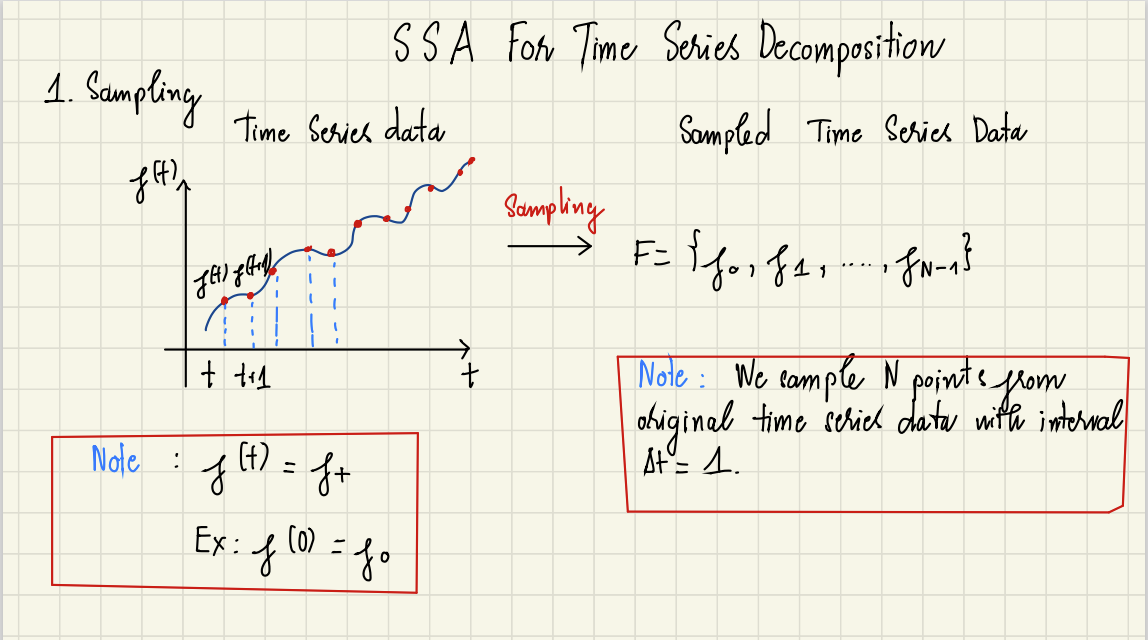

2. Hankelizing

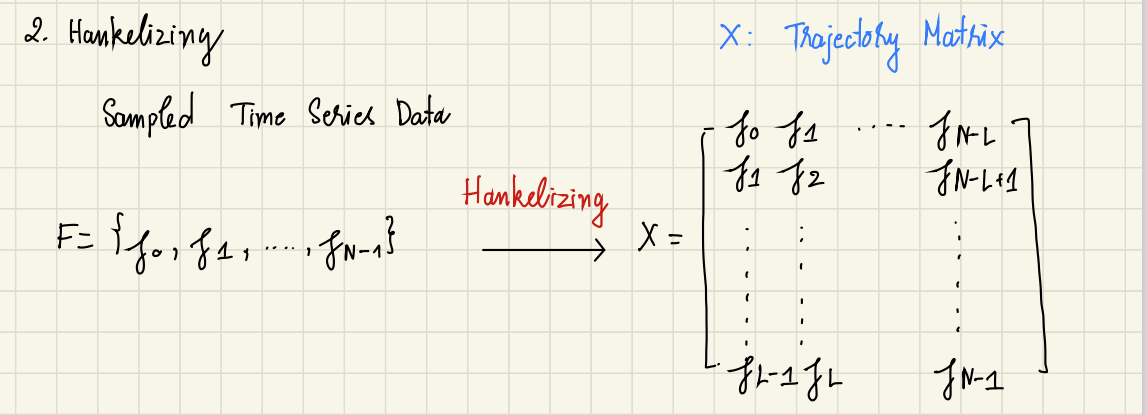

3. Decomposition

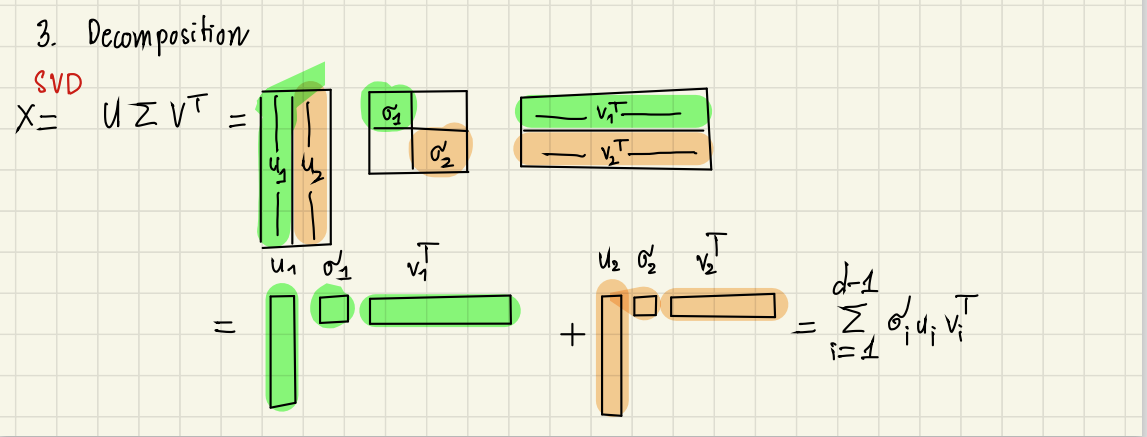

4. Reconstruction

This is the key step of SSA, which each component of decomposed matrix $X_i$ can give us useful information about the original time series. For example,
$X_0$ show us the trend, while $X_1$ give us the seasonality.

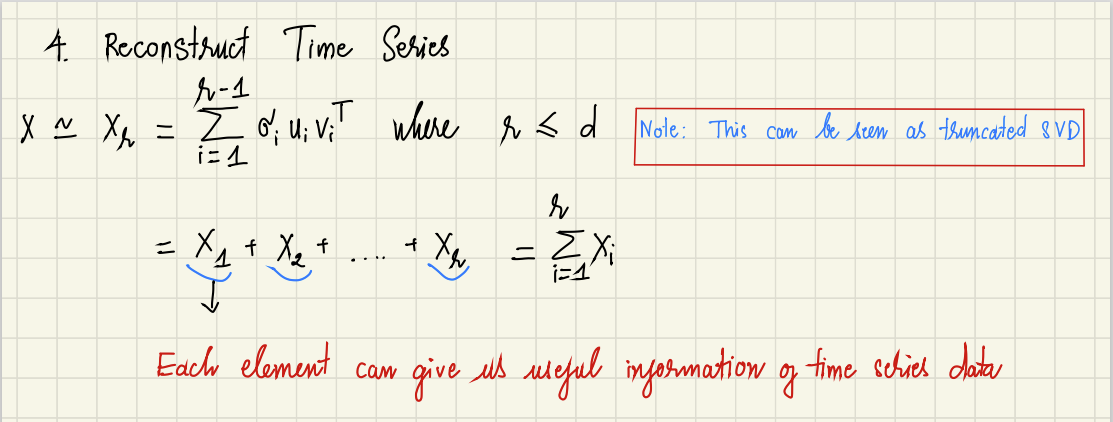

5. Convert Hankel matrix to time series for visualization

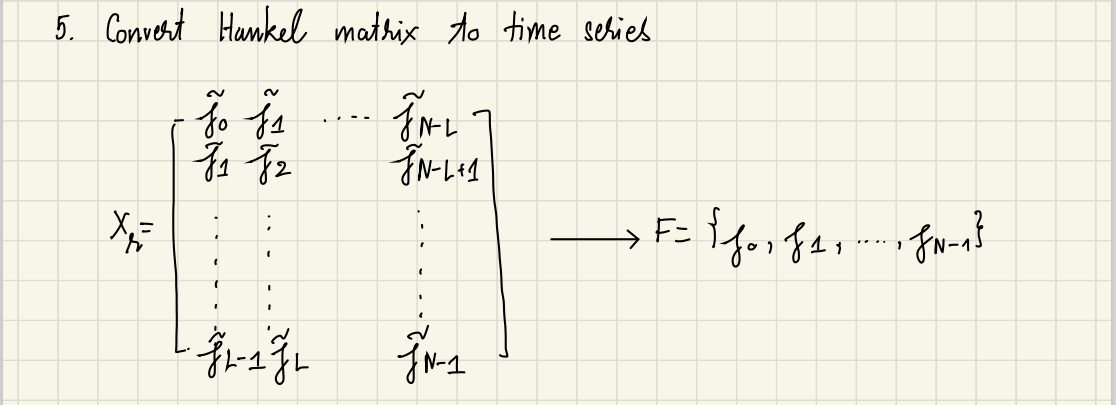

In [2]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Load the usual suspects:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

<h1><center>PCA for Time Series Decomposition</center></h1>

# From SVD to PCA
To use PCA for Time Series Decomposition, I make use of similarity between PCA and SVD. The most important condition is zero expectation of each data column. This alternation is applied to step 3 of original SSA. There are some advantage for this approach:
- The problem formulation only optimizes 1 variable $U_k$ which help us to reduce complexity.
- The problem formulation leverage approaches with manifold learning which help us accelerate training time.
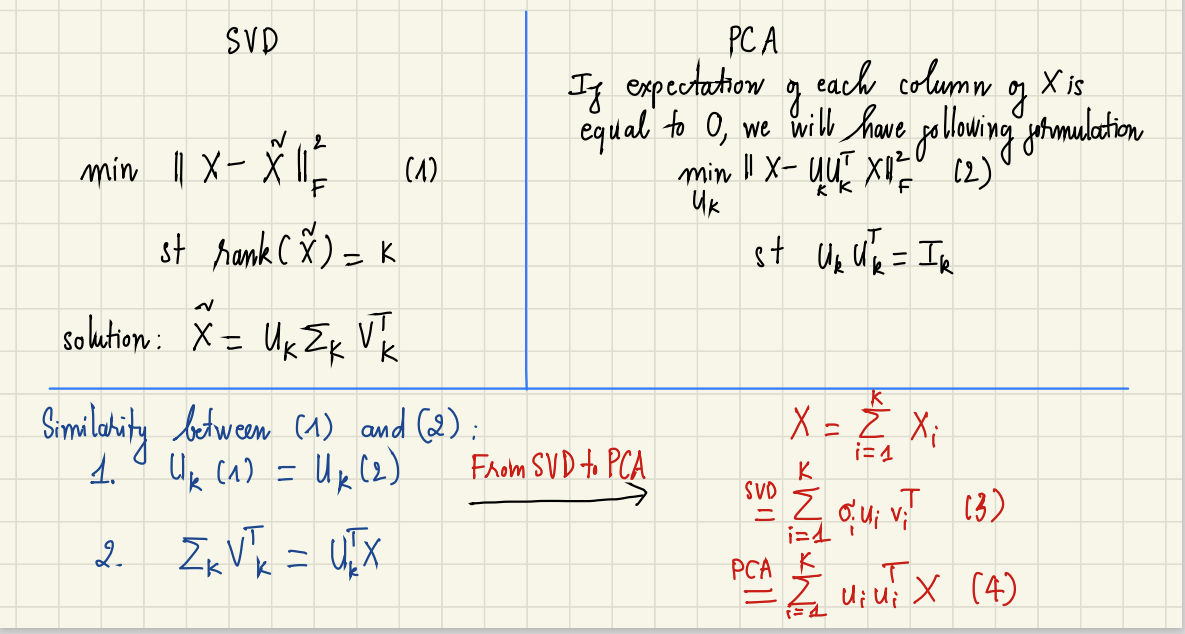

<h1><center>Coding demonstration for Time Series Decomposition with PCA</center></h1>

# Create toy time series data

This section of code use the the same code in the SSA paper. This identical will give us better comparison between PCA and SSA for Time Series Decomposition. Results for SSA using SVD can be found here: https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition/ 

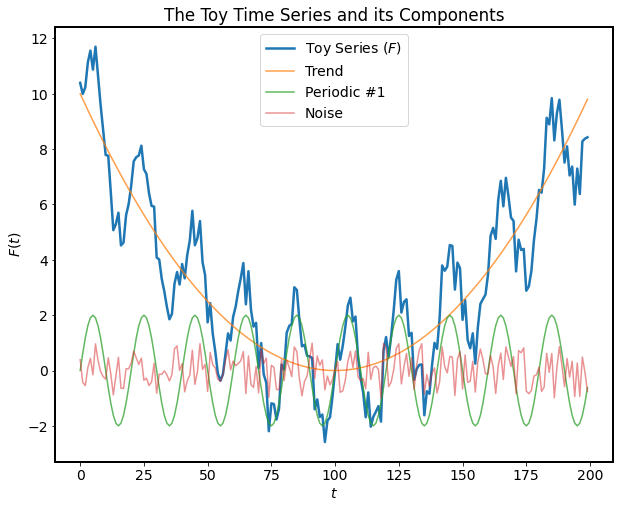

In [4]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2, p3 = 20, 30, 40

periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
# F = trend + periodic1 + periodic2 + noise
F = trend + periodic1 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
# plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
# plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

# Choosing hyper-parameters

In [5]:
L = 20 # The window length
K = N - L + 1  # number of columns in the trajectory matrix

X = np.column_stack([F[i:i+L] for i in range(0,K)])
d = 10

# PCA Decomposition

Audience can use existing PCA from sklearn

In [6]:
import numpy as np

def PCA_decomposition(A):
  M = np.mean(A, axis=0)
  C = A - M
  V = np.cov(C)
  values, vectors = np.linalg.eig(V)
    
  return values, vectors

# Zero mean for each column of data

In [7]:
from sklearn.preprocessing import StandardScaler
sX = StandardScaler(copy=True)
X_trans = sX.fit_transform(X)

# Decompose Time Series using PCA

In [8]:
values, vectors = PCA_decomposition(X)
values.shape, vectors.shape

((20,), (20, 20))

In [9]:
U_k = vectors
U_k.shape

(20, 20)

# Reconstruct $X_i$ by using PCA

In [10]:
X_elem_pca = np.array([np.dot(np.dot(np.expand_dims(U_k[:,i], axis=1), np.expand_dims(U_k[:,i].T, axis=0)), X) for i in range(0,d)])

# Function to Convert Trajectory matrix (Hankel Matrix) to Time Series Data

In [11]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

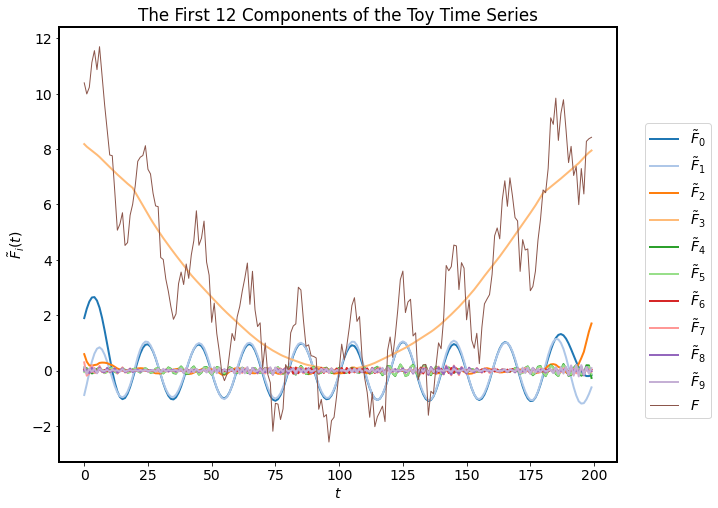

In [12]:
n = min(70,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem_pca[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));

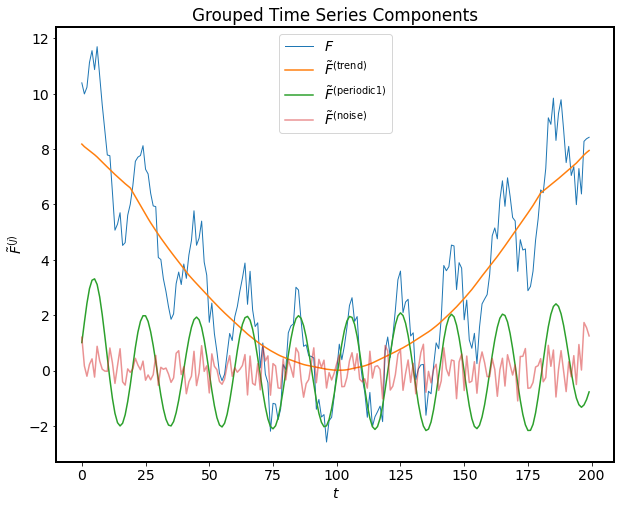

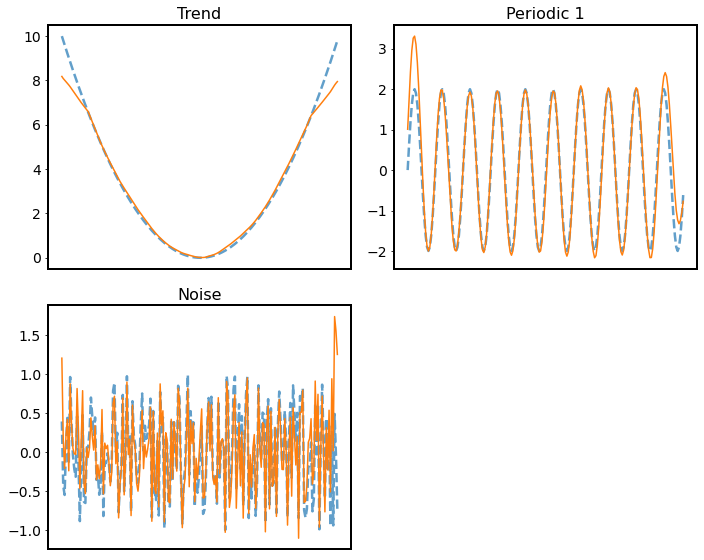

In [13]:
# Assemble the grouped components of the time series.
F_periodic1 = X_to_TS(X_elem_pca[[0,1]].sum(axis=0))
F_trend = X_to_TS(X_elem_pca[[3,]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem_pca[[4,5]].sum(axis=0))
F_noise = X_to_TS(X_elem_pca[7:].sum(axis=0))
F_noise = F - F_trend - F_periodic1
# Plot the toy time series and its separated components on a single plot.
plt.plot(t,F, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
# plt.plot(t, F_periodic2)

plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

# A list of tuples so we can create the next plot with a loop.
components = [("Trend", trend, F_trend), 
              ("Periodic 1", periodic1, F_periodic1),
              # ("Periodic 2", periodic2, F_periodic2),
              ("Noise", noise, F_noise)]

# Plot the separated components and original components together.
fig = plt.figure()
n=1
for name, orig_comp, ssa_comp in components:
    ax = fig.add_subplot(2,2,n)
    ax.plot(t, orig_comp, linestyle="--", lw=2.5, alpha=0.7)
    ax.plot(t, ssa_comp)
    ax.set_title(name, fontsize=16)
    ax.set_xticks([])
    n += 1

fig.tight_layout()